# PRISMO vs NSF on Mouse Brain SlideSeqV2 Data

In [4]:
%load_ext autoreload
%autoreload 2

import sys
import os
parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)

import plotting_settings
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from prismo import PRISMO
from prismo.tl import match
from plotnine import *
import os
import dill as pkl

from data_loader import load_nsf_slideseq

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
data = load_nsf_slideseq()

In [6]:
insfh = pkl.load(open("insfh.pkl", "rb"))
insfh_lda = pkl.load(open("insfh_lda.pkl", "rb"))

In [8]:
insfh["spatial"].keys()

dict_keys(['factors', 'loadings'])

In [9]:
z_nsf = insfh["spatial"]["factors"]
w_nsf = insfh["spatial"]["loadings"]

z_nsf = pd.DataFrame(
    z_nsf,
    columns=[f"Factor {i}" for i in range(z_nsf.shape[1])],
    index=data.obs_names
)

w_nsf = pd.DataFrame(
    w_nsf,
    columns=[f"Factor {i+1}" for i in range(w_nsf.shape[1])],
    index=data.var_names
)

z_prismo = {}
w_prismo = {}
prismo_model = {}
for seed in range(10):
    prismo_model[seed] = PRISMO.load(f"models/prismo_10_{seed}.h5")
    z_prismo[seed] = prismo_model[seed].get_factors()['group_1']
    w_prismo[seed] = prismo_model[seed].get_weights()["view_1"].T

In [13]:
# def postprocess(u, v):
#     u_original = u.copy()
#     v_original = v.copy()

#     if isinstance(u, pd.DataFrame):
#         u = u.values
#     if isinstance(v, pd.DataFrame):
#         v = v.values

#     u_sum = u.sum(axis=0)
#     u = u @ np.diag(1/u_sum)
#     v = v @ np.diag(u_sum)
#     v_sum = v.sum(axis=1)
#     v = np.diag(1/v_sum) @ v

#     if isinstance(u_original, pd.DataFrame):
#         u = pd.DataFrame(u, columns=u_original.columns, index=u_original.index)
#     if isinstance(v_original, pd.DataFrame):
#         v = pd.DataFrame(v, columns=v_original.columns, index=v_original.index)

#     return u, v

# z_nsf, w_nsf = postprocess(z_nsf, w_nsf)

# z_prismo = {}
# w_prismo = {}
# for seed in range(10):
#     z_prismo[seed], w_prismo[seed] = postprocess(z_prismo[seed], w_prismo[seed])

### Factor matching based on correlation

/data/florin/micromamba/envs/prismo/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Helvetica.


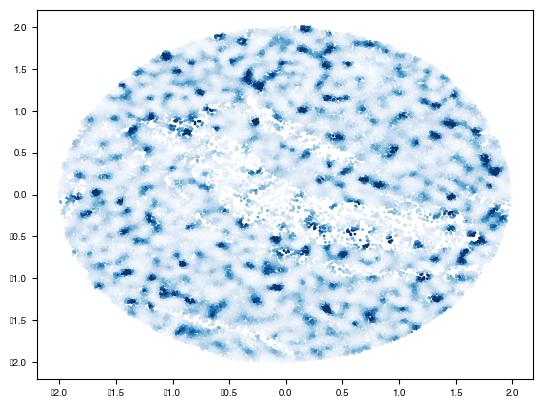

In [11]:
import matplotlib.pyplot as plt
plt.scatter(data.obsm["spatial"][:, 0], data.obsm["spatial"][:, 1], c=z_nsf["Factor 1"], cmap="Blues", s=1, vmax=0.0001)
plt.show()

In [14]:
for seed in range(10):
    nsf_inds, prismo_inds, signs = match(w_nsf, w_prismo[seed], dim=-1)

    z_prismo[seed] = z_prismo[seed].iloc[:, prismo_inds]
    z_prismo[seed] = z_prismo[seed] * signs.reshape(1, -1)
    z_prismo[seed].columns = [f"Factor {i+1}" for i in range(z_prismo[seed].shape[1])]

    for view in w_prismo[seed].keys():
        w_prismo[seed] = w_prismo[seed].iloc[:, prismo_inds]
        w_prismo[seed] = w_prismo[seed] * signs.reshape(1, -1)
        w_prismo[seed].columns = [f"Factor {i+1}" for i in range(w_prismo[seed].shape[1])]

### Reordering factors to have high correlation first

In [15]:
n_factors = z_prismo[0].shape[1]

df = []
for seed in range(10):
    corr = []
    for i in range(n_factors):
        corr.append(pearsonr(w_prismo[seed].iloc[:, i], w_nsf.iloc[:, i])[0].item())
    df.append(pd.DataFrame(corr, columns=[f"corr"]))
    df[-1]["seed"] = seed
    df[-1]["factor"] = [f"{i+1}" for i in range(n_factors)]
    df[-1]["lv"] = "Weights"

df = pd.concat(df, axis=0)
new_order = df.groupby("factor", observed=True)["corr"].mean().sort_values(ascending=False).index.astype(int) - 1

w_nsf = w_nsf.iloc[:, new_order]
w_nsf.columns = [f"Factor {i+1}" for i in range(w_nsf.shape[1])]
z_nsf = z_nsf.iloc[:, new_order]
z_nsf.columns = [f"Factor {i+1}" for i in range(z_nsf.shape[1])]
for seed in range(10):
    w_prismo[seed] = w_prismo[seed].iloc[:, new_order]
    w_prismo[seed].columns = [f"Factor {i+1}" for i in range(w_prismo[seed].shape[1])]
    z_prismo[seed] = z_prismo[seed].iloc[:, new_order]
    z_prismo[seed].columns = [f"Factor {i+1}" for i in range(z_prismo[seed].shape[1])]

### Correlation plots

/data/florin/micromamba/envs/prismo/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 3 rows containing missing values.
/data/florin/micromamba/envs/prismo/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 3 rows containing missing values.


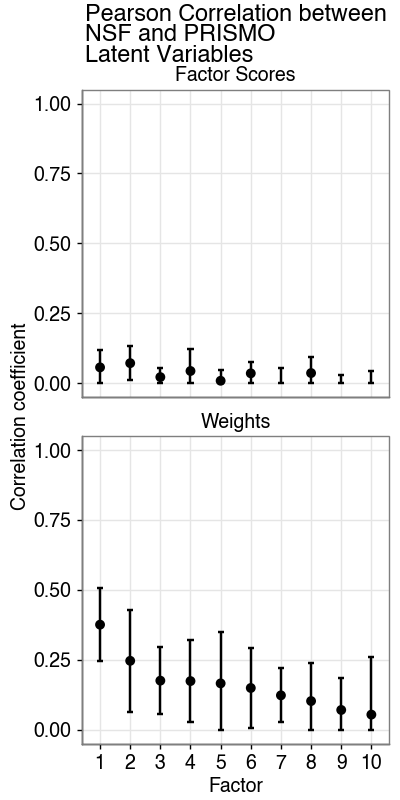

In [16]:
seeds = list(z_prismo.keys())
views = list(w_prismo[seeds[0]].keys())
n_factors = z_prismo[0].shape[1]

df = []
for seed in seeds:
    corr = []
    for i in range(n_factors):
        corr.append(pearsonr(z_prismo[seed].iloc[:, i], z_nsf.iloc[:, i])[0])
    df.append(pd.DataFrame(corr, columns=["corr"]))
    df[-1]["seed"] = seed
    df[-1]["factor"] = [f"{i+1}" for i in range(n_factors)]
    df[-1]["lv"] = "Factor Scores"

    corr = []
    for i in range(n_factors):
        corr.append(pearsonr(w_prismo[seed].iloc[:, i], w_nsf.iloc[:, i])[0].item())
    df.append(pd.DataFrame(corr, columns=[f"corr"]))
    df[-1]["seed"] = seed
    df[-1]["factor"] = [f"{i+1}" for i in range(n_factors)]
    df[-1]["lv"] = "Weights"

df = pd.concat(df, axis=0)

df = df.groupby(["factor", "lv"])["corr"].aggregate(["mean", "std"]).reset_index()
df["min"] = df["mean"] - df["std"]
df["max"] = df["mean"] + df["std"]
df["factor"] = pd.Categorical(df["factor"], categories=[f"{i+1}" for i in range(n_factors)], ordered=True)
df["min"] = np.clip(df["min"], a_min=0., a_max=1.)
df["max"] = np.clip(df["max"], a_min=0., a_max=1.)

plot = (
    ggplot(df, aes(x="factor", y="mean", group="lv"))
    + geom_point(size=1.)
    + geom_errorbar(aes(ymin="min", ymax="max"), width=0.2)
    + facet_wrap("~lv", scales="fixed", ncol=1)
    + theme(
        figure_size=(2, 4),
        panel_spacing_y=0.05
    )
    + labs(x="Factor", y="Correlation coefficient", title="Pearson Correlation between\nNSF and PRISMO\nLatent Variables")
    + ylim(0, 1)
)

fig = plot.draw()
fig.savefig("plots/correlations.pdf")
plot.show()

### Weights scatter plots

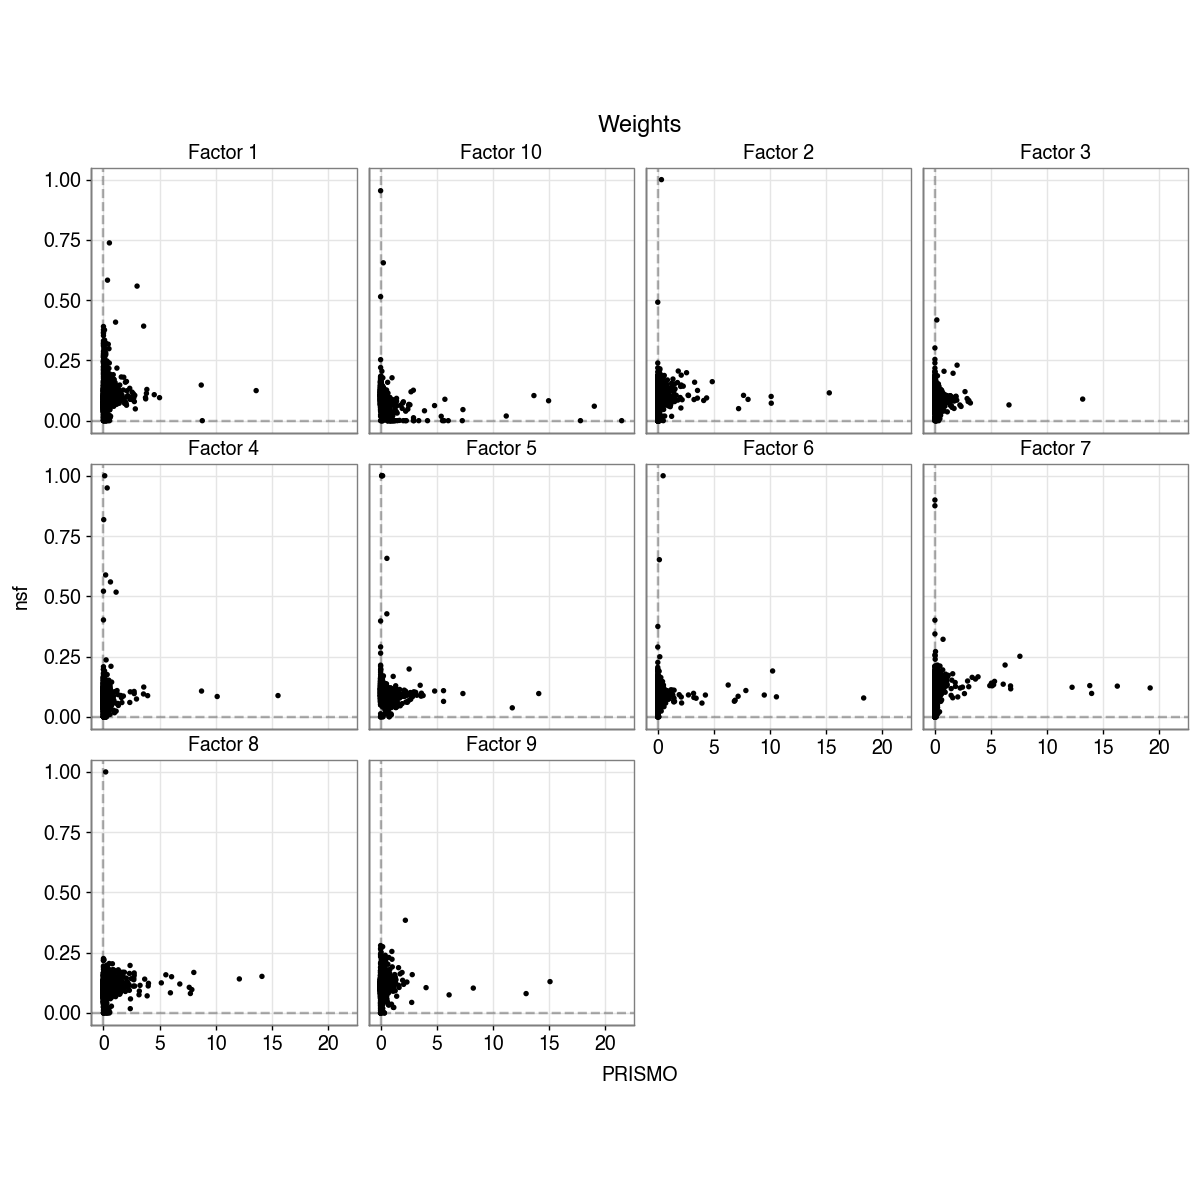

In [8]:
factors = [f"Factor {i}" for i in range(1, w_nsf.shape[1]+1)]
seed = 0

df_list = []
for factor in factors:
    df = pd.DataFrame(w_prismo[seed][factor])
    df.columns = ["weight_prismo"]
    df["weight_nsf"] = w_nsf[factor]
    df["weight_prismo_abs"] = df["weight_prismo"].abs()
    df["weight_nsf_abs"] = df["weight_nsf"].abs()
    df["factor"] = factor
    df_list.append(df)

# Concatenate all the DataFrames
df_all = pd.concat(df_list, ignore_index=True)

plot = (
    ggplot(df_all, aes(x="weight_prismo", y="weight_nsf"))
    + geom_point(size=.1)
    + labs(x="PRISMO", y="nsf", title="Weights")
    + theme(figure_size=(6, 6))
    + geom_hline(yintercept=0, linetype='dashed', color='black', alpha=0.3)
    + geom_vline(xintercept=0, linetype='dashed', color='black', alpha=0.3)
    + facet_wrap("~factor", scales="fixed")
)

fig = plot.draw()
fig.savefig("plots/weights.pdf")
plot.show()

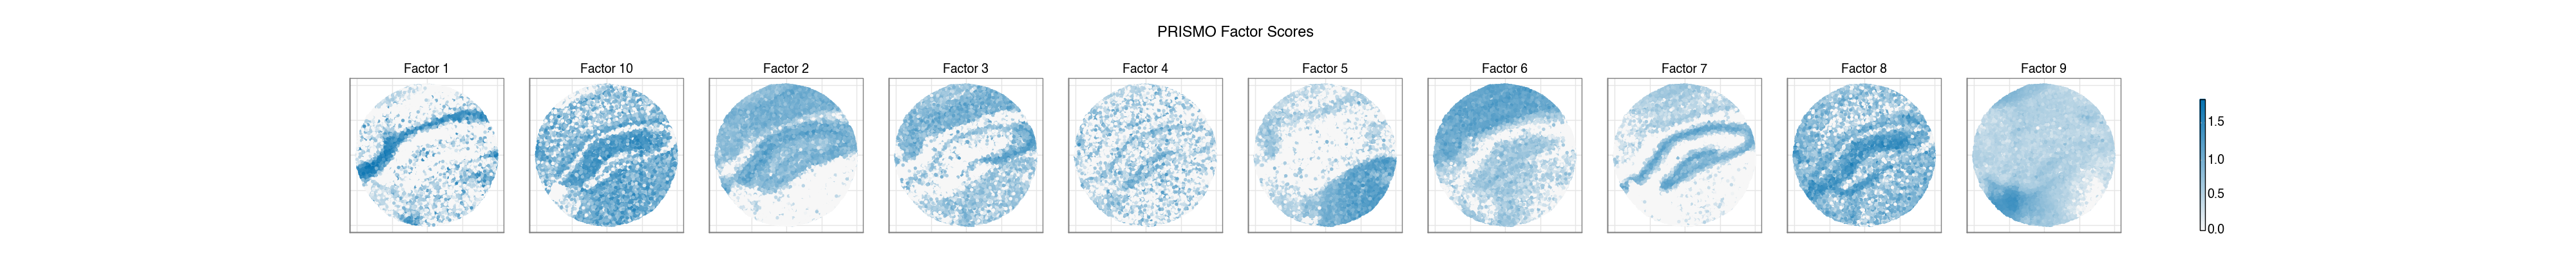

In [9]:
seed = 0

covariates_df = pd.DataFrame(prismo_model[seed].covariates["group_1"], columns=["x", "y"])
factors_df = pd.DataFrame(z_prismo[seed], columns=[f"Factor {i+1}" for i in range(z_prismo[seed].shape[1])])
covariates_df.index = factors_df.index
df = pd.concat([covariates_df, factors_df], axis=1)
df["y"] = -df["y"]
df_long = df.melt(id_vars=["x", "y"], value_vars=[f"Factor {i+1}" for i in range(z_prismo[seed].shape[1])], var_name="Factor", value_name="Score")
df_long["Score"] = np.sqrt(df_long["Score"])

plot = (
    ggplot(df_long, aes(x="x", y="y", color="Score"))
    + geom_point(size=0.1)
    + theme(
        figure_size=(2 * z_prismo[seed].shape[1], 2),
        axis_text_x=element_blank(),
        axis_text_y=element_blank(),
        axis_ticks_major_x=element_blank(),
        axis_ticks_major_y=element_blank(),
        legend_key_width=3.,
    )
    + labs(x="", y="", color="", title="PRISMO Factor Scores")
    + coord_fixed(ratio=1)
    + scale_color_gradient(low="#f7f7f7", high="#0571b0")
    + facet_wrap("~Factor", nrow=1)
)

fig = plot.draw()
fig.savefig("plots/prismo_factors.pdf")
plot.show()

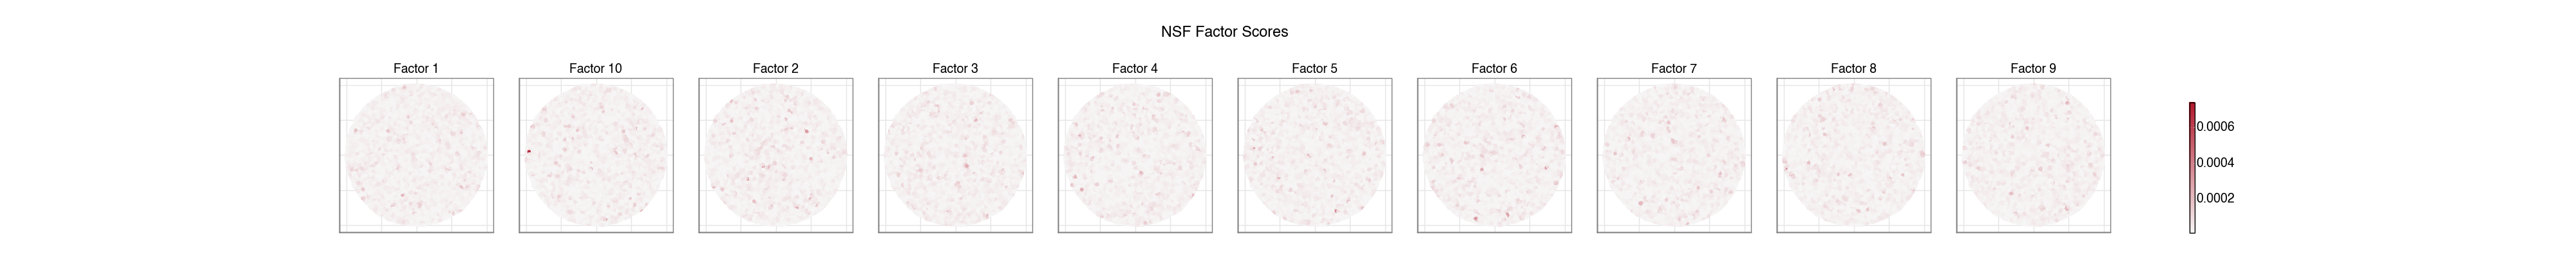

In [10]:
covariates_df = pd.DataFrame(prismo_model[1].covariates["group_1"], columns=["x", "y"])
factors_df = pd.DataFrame(z_nsf.values, columns=[f"Factor {i+1}" for i in range(z_nsf.shape[1])])
covariates_df.index = factors_df.index
df = pd.concat([covariates_df, factors_df], axis=1)
df["y"] = -df["y"]
df_long = df.melt(id_vars=["x", "y"], value_vars=[f"Factor {i+1}" for i in range(z_nsf.shape[1])], var_name="Factor", value_name="Score")

plot = (
    ggplot(df_long, aes(x="x", y="y", color="Score"))
    + geom_point(size=0.1)
    + theme(
        figure_size=(2 * z_nsf.shape[1], 2),
        axis_text_x=element_blank(),
        axis_text_y=element_blank(),
        axis_ticks_major_x=element_blank(),
        axis_ticks_major_y=element_blank(),
        legend_key_width=3.,
    )
    + labs(x="", y="", color="", title="NSF Factor Scores")
    + coord_fixed(ratio=1)
    + scale_color_gradient(low="#f7f7f7", high="#B2182B")
    + facet_wrap("~Factor", nrow=1)
)

fig = plot.draw()
fig.savefig("plots/nsf_factors.pdf")
plot.show()

,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9
AAAAAAAGTCCCAA,0.234016,0.995939,2.311698,0.806348,0.428613,0.188383,0.150137,0.240054,0.119923,0.030762
AAAAAACATCTTTC,6.666540,0.475681,0.284809,0.361224,0.442321,0.635140,2.182802,0.565314,2.329402,0.481555
AAAAAACTTCTACT,0.213893,0.240372,0.735068,0.538233,0.050615,0.539170,0.442961,0.317540,0.979569,0.316705
AAAAAATTTACAAC,0.476523,0.205049,0.221612,0.392232,0.178398,0.195155,0.104205,1.454150,0.298873,0.059255
AAAAACACGGTGGT,2.160803,0.627109,1.061225,1.007997,1.294150,1.588615,0.899780,0.289771,0.247697,1.310394
...,...,...,...,...,...,...,...,...,...,...
TTTTTTCGTTCCGA,1.106576,0.613329,0.432125,0.780709,0.188111,0.302590,0.097009,0.405632,0.086716,0.969951
TTTTTTTCTGACGG,0.389155,0.165396,0.137945,0.317627,0.563718,0.476531,5.521217,0.284906,0.653837,0.319730
TTTTTTTCTGCAGT,0.265884,0.226110,0.332512,0.146508,0.040523,1.120219,0.144160,0.459144,0.820716,0.100158
TTTTTTTCTGCCAT,0.663473,0.124750,0.332803,0.490248,0.521568,0.197689,0.416234,0.127901,0.436964,0.152640


In [35]:
df = pd.read_csv("nsf-paper/scrna/sshippo/results/benchmark.csv")

df[(df.model=="NSF") & (df.lik=="poi")]

,V,L,model,kernel,M,lik,sz,key,converged,epochs,...,dev_tr_max,dev_tr_med,rmse_tr,dev_val_mean,dev_val_argmax,dev_val_max,dev_val_med,rmse_val,sparsity,elbo_avg_val
30,5,6,NSF,MaternThreeHalves,1000.0,poi,constant,V5/L6/poi_sz-constant/NSF_MaternThreeHalves_M1000,True,180.0,...,3.118950,2.523749,1.293793,2.497683,0.0,3.387205,2.494120,1.265018,0.053333,-1141.711914
31,5,6,NSF,MaternThreeHalves,2000.0,poi,constant,V5/L6/poi_sz-constant/NSF_MaternThreeHalves_M2000,True,200.0,...,3.085880,2.460037,1.251552,2.490355,0.0,3.325081,2.486498,1.236792,0.055083,-1141.297852
32,5,6,NSF,MaternThreeHalves,3000.0,poi,constant,V5/L6/poi_sz-constant/NSF_MaternThreeHalves_M3000,True,210.0,...,3.142905,2.416312,1.237071,2.496929,0.0,3.355996,2.492590,1.239658,0.048833,-1156.949707
33,5,6,NSF,MaternThreeHalves,1000.0,poi,scanpy,V5/L6/poi_sz-scanpy/NSF_MaternThreeHalves_M1000,True,140.0,...,3.617850,1.963747,0.952842,1.963110,0.0,3.604248,1.961219,0.910622,0.076333,-966.661133
34,5,6,NSF,MaternThreeHalves,2000.0,poi,scanpy,V5/L6/poi_sz-scanpy/NSF_MaternThreeHalves_M2000,True,150.0,...,3.451758,1.944656,0.906922,1.946804,0.0,3.511792,1.945119,0.844648,0.096583,-958.783325
35,5,6,NSF,MaternThreeHalves,3000.0,poi,scanpy,V5/L6/poi_sz-scanpy/NSF_MaternThreeHalves_M3000,True,160.0,...,3.329329,1.934623,0.871846,1.948153,0.0,3.306627,1.946712,0.829629,0.105083,-960.017029
45,5,12,NSF,MaternThreeHalves,1000.0,poi,constant,V5/L12/poi_sz-constant/NSF_MaternThreeHalves_M...,True,210.0,...,2.775954,2.483251,1.276092,2.464706,11.0,2.853916,2.461245,1.245702,0.091500,-1130.755005
46,5,12,NSF,MaternThreeHalves,2000.0,poi,constant,V5/L12/poi_sz-constant/NSF_MaternThreeHalves_M...,True,240.0,...,2.665660,2.413792,1.242526,2.453184,4.0,2.832480,2.449099,1.210194,0.090583,-1144.312378
47,5,12,NSF,MaternThreeHalves,3000.0,poi,constant,V5/L12/poi_sz-constant/NSF_MaternThreeHalves_M...,True,190.0,...,2.591535,2.382675,1.224951,2.470469,6.0,2.781049,2.466925,1.241169,0.095750,-1166.139038
48,5,12,NSF,MaternThreeHalves,1000.0,poi,scanpy,V5/L12/poi_sz-scanpy/NSF_MaternThreeHalves_M1000,True,150.0,...,2.674522,1.928437,0.924753,1.926289,0.0,3.088258,1.924289,0.896671,0.135083,-957.422791


In [11]:
import dill as pkl

insf = pkl.load(open("insf.pkl", "rb"))

In [13]:
insf["spatial"]["factors"]

(36536, 10)

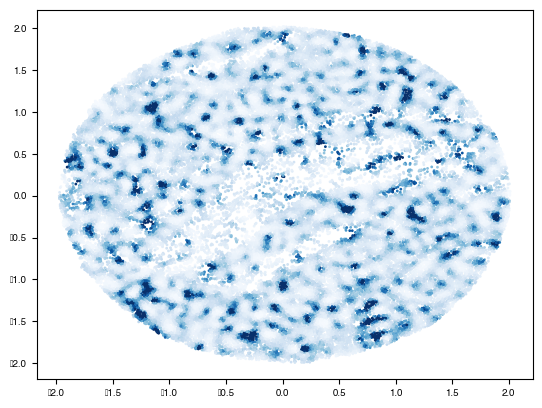

In [16]:
import matplotlib.pyplot as plt
plt.scatter(spatial[:, 0], spatial[:, 1], c=insf["spatial"]["factors"][:, 2], cmap="Blues", s=1, vmax=0.0001)
plt.show()